### Import Modules

In [1]:
import csv
import glob
import io
import math
import os
import warnings
from collections import defaultdict
from random import shuffle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Read Data

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
df = pd.read_csv('Institution_data_final.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6,1547,1575,1576,1577,1587,1588,1729,1909,1910,1911,1912,1913) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
df.columns

Index(['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'ZIP',
       'ACCREDAGENCY', 'INSTURL', 'NPCURL',
       ...
       'COUNT_WNE_MALE1_P8', 'MD_EARN_WNE_MALE1_P8', 'GT_THRESHOLD_P10',
       'MD_EARN_WNE_INC1_P10', 'MD_EARN_WNE_INC2_P10', 'MD_EARN_WNE_INC3_P10',
       'MD_EARN_WNE_INDEP1_P10', 'MD_EARN_WNE_INDEP0_P10',
       'MD_EARN_WNE_MALE0_P10', 'MD_EARN_WNE_MALE1_P10'],
      dtype='object', length=2989)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7869 entries, 0 to 7868
Columns: 2989 entries, UNITID to MD_EARN_WNE_MALE1_P10
dtypes: float64(1719), int64(12), object(1258)
memory usage: 179.4+ MB


### Data Preprocessing 

#### Standardize data

In [18]:
object_list = []
for col in df.columns:
    if df[col].dtypes == 'object':
        object_list.append(col)

In [19]:
del object_list[0:4]
# Exclude unitid, zipcode, opeid, city, state postcode

In [20]:
# convert the data type from object to float
for col in object_list:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [24]:
earning_10y = df[~df['MN_EARN_WNE_P10'].isnull()]['MN_EARN_WNE_P10']

####  Filter out outliers

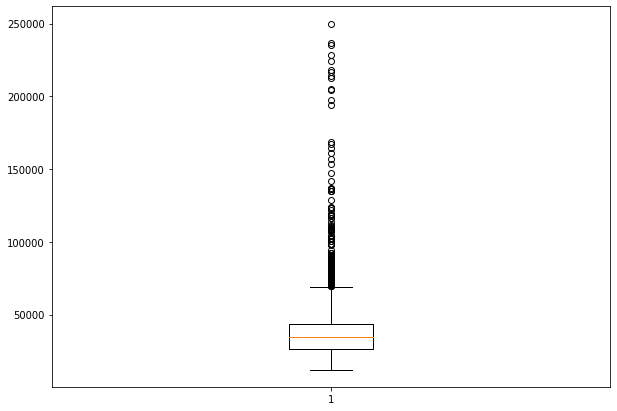

In [26]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(earning_10y )
# show plot
plt.show()

In [9]:
df = df[~(np.abs(df['MN_EARN_WNE_P10']-df['MN_EARN_WNE_P10'].mean()) > (3*df['MN_EARN_WNE_P10'].std()))]

#### Correlation

First of all, for the selection of key indicatorsn, after comparing the distribution of students' earning 1,3,6,10 years after graduation, I think the '10 years later' data is more representative, because earnings of graduated students don't change too much in the early stage of their career and they might consider pursuing another degree or trying a variety of positions in a different industry, which makes the earnings in the early years after graduation may not be indicative of longer-term earnings.


Use MN_EARN_WNE_P10 as the key feature, which indicate the earnings of students working and not enrolled 10 years after entry. Calculated the correlation between the key feature and other attributes to process the initial selection.

In [15]:
# MN_EARN_WNE_P10: mean earnings of students working and not enrolled 10 years after entry
df['MN_EARN_WNE_P10'] = pd.to_numeric(df.MN_EARN_WNE_P10.astype(str).str.replace(',',''), errors='coerce')

In [16]:
corr_matrix = df.corrwith(df["MN_EARN_WNE_P10"])

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [17]:
corr_table = pd.DataFrame(corr_matrix).reset_index()
corr_table.columns = ['Feature','Correlation']

Exclude features whose name contain 'EARN' or 'DEATH' or '25K', and selecte those with correlation over 0.5.

In [18]:
corr_table_final = corr_table[(corr_table['Feature'].str.contains('EARN')==0) &
                              (corr_table['Feature'].str.contains('DEATH')==0) &
                             (corr_table['Feature'].str.contains('25K')==0)
                              & (corr_table['Correlation']>0.6)
                             ]
corr_table_final

,Feature,Correlation
34,SATVR25,0.681315
35,SATVR75,0.620273
36,SATMT25,0.747645
37,SATMT75,0.714006
38,SATWR25,0.701899
...,...,...
1711,COMPL_RPY_3YR_RT_SUPP,0.640910
1712,NONCOM_RPY_3YR_RT_SUPP,0.629624
1715,PELL_RPY_3YR_RT_SUPP,0.607054
1718,MALE_RPY_3YR_RT_SUPP,0.642217


Only considered one feature in each category, eg: 25th percentile of the ACT cumulative score, 75th percentile of the ACT cumulative score, 25th percentile of the ACT math score all have correlation score over the threshold, and I would only keep one in the final selected list because they are also correlated with each other.

In [19]:
df[['MN_EARN_WNE_P10', 'ADM_RATE', 'SAT_AVG', 'AVGFACSAL', 'INEXPFTE', 'NPT4_PUB', 'NPT4_PRIV', 'PPTUG_EF',
         'ACTMT25','MALE_RPY_7YR_RT','IND_RPY_7YR_RT','COMPL_RPY_7YR_RT']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7869 entries, 0 to 7868
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MN_EARN_WNE_P10   6158 non-null   float64
 1   ADM_RATE          2241 non-null   float64
 2   SAT_AVG           1431 non-null   float64
 3   AVGFACSAL         4685 non-null   float64
 4   INEXPFTE          7418 non-null   float64
 5   NPT4_PUB          1926 non-null   float64
 6   NPT4_PRIV         4774 non-null   float64
 7   PPTUG_EF          7119 non-null   float64
 8   ACTMT25           1176 non-null   float64
 9   MALE_RPY_7YR_RT   4547 non-null   float64
 10  IND_RPY_7YR_RT    4848 non-null   float64
 11  COMPL_RPY_7YR_RT  4673 non-null   float64
dtypes: float64(12)
memory usage: 737.8 KB


In [20]:
check_list = ['MN_EARN_WNE_P10', 'ADM_RATE', 'SAT_AVG', 'AVGFACSAL', 'INEXPFTE', 'PPTUG_EF',
                     'ACTMT25','MALE_RPY_7YR_RT','IND_RPY_7YR_RT','COMPL_RPY_7YR_RT']

df[check_list].mean()

MN_EARN_WNE_P10     37455.911010
ADM_RATE                0.683778
SAT_AVG              1057.555556
AVGFACSAL            6020.397866
INEXPFTE             6978.961984
PPTUG_EF                0.224076
ACTMT25                19.495748
MALE_RPY_7YR_RT         0.619306
IND_RPY_7YR_RT          0.573881
COMPL_RPY_7YR_RT        0.736994
dtype: float64

#### Feature Selection

In [21]:
final_selected_list = ['ADM_RATE', 'SAT_AVG', 'AVGFACSAL', 'INEXPFTE', 'PPTUG_EF',#'COMPL_RPY_7YR_RT','IND_RPY_7YR_RT'
                   'ACTMT25','MALE_RPY_7YR_RT']

key_metric = ['MN_EARN_WNE_P10']

In [22]:
final_selected_mean = df[final_selected_list].mean()

#### Fill Missing Value

In [30]:
df[check_list] = df[check_list].fillna(df[check_list].mean())

In [31]:
y_to_use = np.array(df[key_metric[0]])

In [32]:
x_to_use = np.array(df[final_selected_list])

### Build Model

In [33]:
def k_means(k, x):
    # do k_means
    total_row = x.shape[0]
    total_col = x.shape[1]
    mu = []
    init_mu_index = []
    # initialize the mu
    while len(init_mu_index) < k:
        index = np.random.randint(total_row)
        # prevent same mean (may need to change)
        if index not in init_mu_index:
            init_mu_index.append(index)
            mu.append(x[index])

    it = 0
    previous_total_loss = None
    total_loss = None
    while previous_total_loss is None or total_loss - previous_total_loss < 0:
        
        # update c
        c = np.zeros(total_row)
        for cur_row in range(total_row):
            x_i = x[cur_row]
            first_v = x_i - mu[0]
            min_loss = np.dot(first_v, first_v)
            min_j = 0
            for j in range(k):
                v = x_i - mu[j]
                cur_loss = np.dot(v, v)
                if cur_loss < min_loss:
                    min_j = j
                    min_loss = cur_loss
            c[cur_row] = min_j
        # update mu
        for j in range(k):
            # numerator and denominator for mu_j
            mu_j_num = np.zeros(total_col)
            mu_j_den = 0
            for cur_row in range(total_row): 
                if c[cur_row] == j:
                    mu_j_num += x[cur_row]
                    mu_j_den += 1
            mu[j] = 0
            if mu_j_den != 0:
                mu[j] = 1 / mu_j_den * mu_j_num
        it += 1
        # get loss function 
        previous_total_loss = total_loss
        total_loss = 0
        for cur_row in range(total_row):
            x_i = x[cur_row]
            mu_j = mu[int(c[cur_row])]
            v = x_i - mu_j
            total_loss += np.dot(v, v)
    return c , mu, total_loss

In [34]:
list = ['MN_EARN_WNE_P10', 'ADM_RATE', 'SAT_AVG', 'AVGFACSAL', 'INEXPFTE', 'PPTUG_EF',
                     'ACTMT25','MALE_RPY_7YR_RT']

In [35]:
data_transformed = df[list]

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,7)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

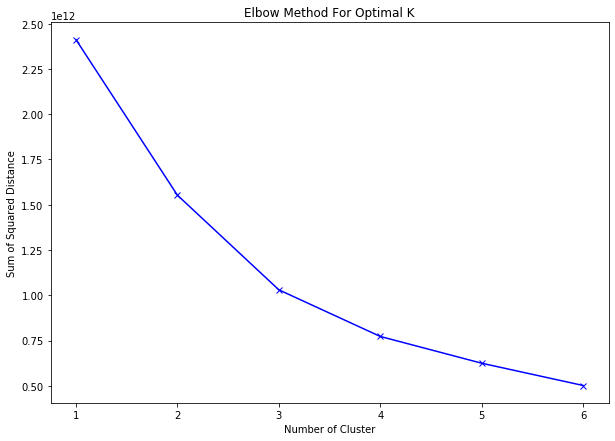

In [48]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Cluster')
plt.ylabel('Sum of Squared Distance')
plt.title('Elbow Method For Optimal K')
plt.show()

From the plot above, it shows that K = 3 or 4 is the optimal number of cluster. After checking the performance by generating 3 or 4 clusters, I decided to use K = 4.

In [39]:

min_seed = 0
min_loss = None
for i in range(10):
    x = np.random.randint(2**31)
    np.random.seed(x)
    k_clus = 4
    cluster, cluster_mean, total_loss = k_means(k_clus, x_to_use)
    if min_loss == None:
        min_loss = total_loss
        min_seed = x
    elif min_loss > total_loss:
        min_seed = x
        min_loss = total_loss


In [ ]:
#min_seed = 1328509290
np.random.seed(1328509290)

In [40]:

cluster, cluster_mean, total_loss = k_means(k_clus, x_to_use)
print('Average error is ', total_loss / x_to_use.shape[0])

Average error is  17880213.124089874


After checking the segmentation result, it shows that those institutions with higher graduate incomes also have stricter admissions requirements, including higher standardized test scores (SAT and ACT) and lower acceptance rates. They also have stricter requirements on educational methods, such as less tolerance for part-time students, and a greater desire for students to focus on their studies.  In addition to this, they also have better staff and student benefits such as higher faculty salary and higher instructional expenditure.

### Segmentation 

In [41]:
avg_earning = [0 for i in range(k_clus)]
avg_earning_count = [0 for i in range(k_clus)]

In [42]:
for cur_cluster in range(len(cluster)):

    i = int(cluster[cur_cluster])
    avg_earning[i] += df.loc[cur_cluster, [key_metric[0]]].astype(float)
    avg_earning_count[i] += 1

In [43]:
for i in range(k_clus):
    avg_earning[i] /= avg_earning_count[i] 

In [44]:
for i in range(k_clus):
    print()
    print(avg_earning_count[i])
    print("The average earning after 10 yrs in this cluster ", i, " is ", avg_earning[i])
    for ind in range(len(final_selected_list)):
        print(final_selected_list[ind], ' is ', cluster_mean[i][ind])
    print()


6262
The average earning after 10 yrs in this cluster  0  is  MN_EARN_WNE_P10    34642.40604
Name: 0, dtype: float64
ADM_RATE  is  0.6928069498262818
SAT_AVG  is  1049.9343127862421
AVGFACSAL  is  5656.5770755287385
INEXPFTE  is  4599.604576005664
PPTUG_EF  is  0.2399611260261514
ACTMT25  is  19.32539415478726
MALE_RPY_7YR_RT  is  0.5975999081211425


19
The average earning after 10 yrs in this cluster  1  is  MN_EARN_WNE_P10    88793.660792
Name: 234, dtype: float64
ADM_RATE  is  0.528183527090819
SAT_AVG  is  1170.9356725146195
AVGFACSAL  is  9489.430680222433
INEXPFTE  is  118089.05263157895
PPTUG_EF  is  0.15190805331913831
ACTMT25  is  21.970327604726112
MALE_RPY_7YR_RT  is  0.706787275814136


166
The average earning after 10 yrs in this cluster  2  is  MN_EARN_WNE_P10    67446.254847
Name: 74, dtype: float64
ADM_RATE  is  0.5507423581877705
SAT_AVG  is  1150.285809906295
AVGFACSAL  is  8638.982643916104
INEXPFTE  is  37518.0
PPTUG_EF  is  0.150132822905613
ACTMT25  is  21.34611

### PCA

In [45]:
#indicator_mean = indicator_mean[1:len(indicator_mean)]

# subtract by the mean
for i in range(x_to_use.shape[0]):
    for j in range(x_to_use.shape[1]):
        x_to_use[i][j] -= final_selected_mean[j]
    # Find  variance
ind_var = [0 for i in range(x_to_use.shape[1])]
for i in range(x_to_use.shape[0]):
    for j in range(x_to_use.shape[1]):
        ind_var[j] += np.power(float(x_to_use[i][j]), 2)
for i in range(len(ind_var)):
    ind_var[i] /= x_to_use.shape[0]
    ind_var[i] = np.sqrt(ind_var[i])
# divided by variance
for i in range(x_to_use.shape[0]):
    for j in range(x_to_use.shape[1]):
        x_to_use[i][j] /= ind_var[j]

sigma = 0
for i in range(x_to_use.shape[0]):
    v = x_to_use[i]
    sigma += np.outer(v, v)
sigma *= (1 / x_to_use.shape[0])
w, v = np.linalg.eig(sigma)
# need the first 2 eigenvectors (2-dim)
u = [v[:,0], v[:,1]]
y = np.zeros((x_to_use.shape[0], 2))
y_max = [0 for i in range(2)]
y_min = [0 for i in range(2)]
for i in range(x_to_use.shape[0]):
    for j in range(2):
        cur_u = u[j]
        y[i][j] = np.dot(cur_u, x_to_use[i])
        if y[i][j] > y_max[j]:
            y_max[j] = y[i][j]
        if y[i][j] < y_min[j]:
            y_min[j] = y[i][j] 

In [46]:
y = pd.read_csv('y.csv')
del y['Unnamed: 0']
y = np.array(y)

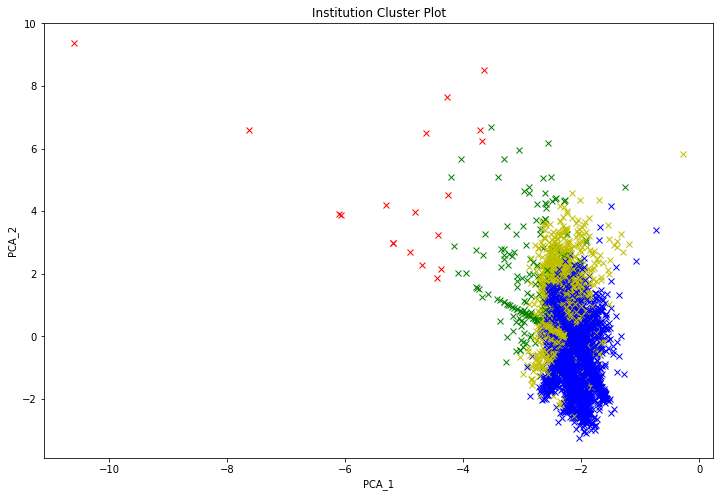

In [47]:
fig, ax = plt.subplots(figsize=(12,8))
for i in range(y.shape[0]):
    # jth cluster 
    j = cluster[i]
    if j == 0:
        plt.plot(y[i][0], y[i][1], 'bx')
    elif j == 1:
        plt.plot(y[i][0], y[i][1], 'rx')
    elif j == 2:
        plt.plot(y[i][0], y[i][1], 'gx')
    elif j == 3:
        plt.plot(y[i][0], y[i][1], 'yx')
    else:
        plt.plot(y[i][0], y[i][1], 'mx')

plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.title('Institution Cluster Plot')
plt.show()